# **Airbnb Content-Based Recommendation System**

![](https://assets3.thrillist.com/v1/image/1451130/size/tmg-article_main_wide_2x.jpg)

## **Introduction**
In this notebook, I will attempt at implementing a recommendation algorithms (content-based). Here we will use listings data from Airbnb around Seattle area. The engine will learn from:
1. id: listings id for every room around Seattle
2. name: the title of room listings
3. description: details given by the host to describe their rooms

## **Objective:** 
* Learning from data and recommend the best rooms around Seattle to users, based on content similarities (name and description)
* Providing more room options and increasing personalization to prospective guests

In [2]:
# Importing the libraries
import pandas as pd
from IPython.display import Image, HTML
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [3]:
# Importing the dataset
listings = pd.read_csv('/home/apprenant/Documents/Brief-13-FoodFlix-NLP/data/02_intermediate/listings.csv', usecols = ['id', 'name', 'description'])
listings.head(10)

,id,name,description
0,241032,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...
5,5956968,Private unit in a 1920s mansion,We're renting out a small private unit of one ...
6,1909058,Queen Anne Private Bed and Bath,Enjoy a quiet stay in our comfortable 1915 Cra...
7,856550,Tiny Garden cabin on Queen Anne,"Our tiny cabin is private , very quiet and com..."
8,4948745,Urban Charm || Downtown || Views,"Nestled in the heart of the city, this space i..."
9,2493658,Airy + Bright Queen Anne Apartment,"Beautiful apartment in an extremely safe, quie..."


## Exploratory Data Analysis
Are there certain words that figure more often in listings' name and description? I suspect there are some words which are occured more frequently and considered more worthy of a title. Let us find out!

In [4]:
listings['name'] = listings['name'].astype('str')
listings['description'] = listings['description'].astype('str')

In [5]:
name_corpus = ' '.join(listings['name'])
description_corpus = ' '.join(listings['description'])

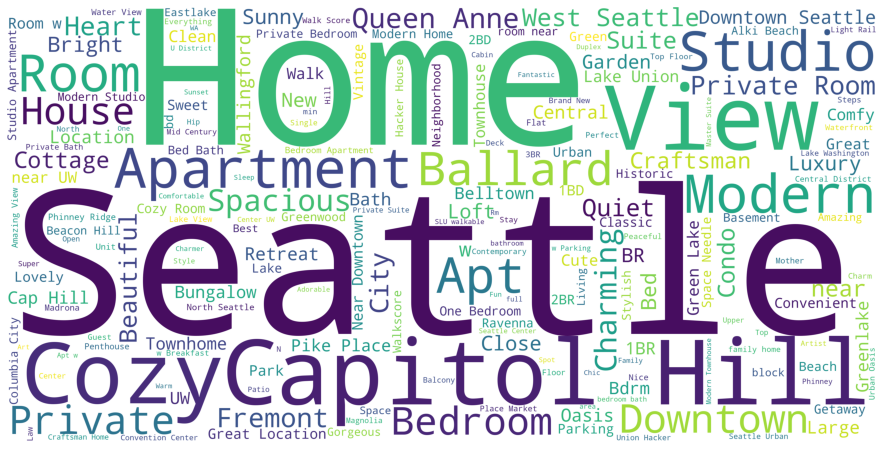

In [6]:
name_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(name_corpus)
plt.figure(figsize = (16,8))
plt.imshow(name_wordcloud)
plt.axis('off')
plt.show()

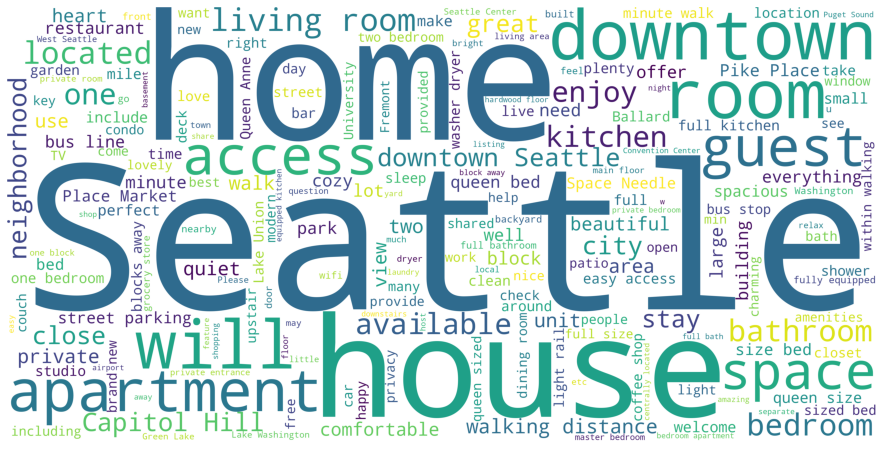

In [7]:
description_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(description_corpus)
plt.figure(figsize = (16,8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()

The most frequently words occurred in the name or title of listings are including: Seattle, Capitol Hill, View, Home, Cozy, etc. This obviously represents Seattle area data with common words in room listings. Unlike for the description, here some of the tops are already specific like: house, home, apartment, living room, space. They are typical words for hosts when describing their listings.

Now, we create a column containing a combination of name and description columns that is important for content-based recommendation system

In [8]:
listings['content'] = listings[['name', 'description']].astype(str).apply(lambda x: ' // '.join(x), axis = 1)

In [9]:
# Fillna
listings['content'].fillna('Null', inplace = True)

## Train the Recommender

## TF-IDF (Term Frequency - Inverse Document Frequency)
Create a TF-IDF matrix of unigrams and bigrams for each id or room. The “stop words” parameter tells the TF-IDF module to ignore common English words like 'the', ‘about’, etc.  TF-IDF will parse through the descriptions, identify distinct phrases in each item's description, and then find similar contents based on those phrases. Formula is below:

𝑤_(𝑖,𝑗)=〖𝑡𝑓〗_(𝑖,𝑗)  x log⁡(𝑁/〖𝑑𝑓〗_𝑖 )


𝑡𝑓〗_(𝑖,𝑗) = number of occurrences of i in j;
〖𝑑𝑓〗_𝑖 = number of documents containing i;
𝑁 = total number of documents

In [10]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')
tfidf_matrix = tf.fit_transform(listings['content'])

## Cosine Similarity
Cosine Similarity calculates similarity by measuring the cosine angle between two vectors. Vectors are converted from contents by TF-IDF and this measurement will identify which contents are closest to each other.


In [11]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [21]:
cosine_similarities[0]

array([1.        , 0.05619772, 0.03742817, ..., 0.03470973, 0.03496357,
       0.05157407])

Iterate through each item's similar items and store the 100 most-similar!

In [12]:
results = {}
for idx, row in listings.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-10:-1]
    similar_items = [(cosine_similarities[idx][i], listings['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]

In [26]:
listings['id'][0]

241032

## Let's make a prediction

Create two functions for showing the recommender results:
1. Function to get a friendly item name and description from the content field, given an item ID
2. Function to read the results out of the dictionary

In [13]:
def item(id):
    name   = listings.loc[listings['id'] == id]['content'].tolist()[0].split(' // ')[0]
    desc   = ' \nDescription: ' + listings.loc[listings['id'] == id]['content'].tolist()[0].split(' // ')[1][0:165] + '...'
    prediction = name  + desc
    return prediction

def recommend(item_id, num):
    print('Recommending ' + str(num) + ' products similar to ' + item(item_id))
    print('---')
    recs = results[item_id][:num]
    for rec in recs:
        print('\nRecommended: ' + item(rec[1]) + '\n(score:' + str(rec[0]) + ')')

Finally, try to put an id from listings data and number of recommendation to show

In [14]:
recommend(item_id = 4085439, num = 5)

Recommending 5 products similar to Historic Ballard House 
Description: Built in 1900 in the heart of Ballard, our house is conveniently located within walking distance to some of Seattle's best restaurants and shops, the Hiram Chittende...
---

Recommended: Restful Room w/Bath in West Ballard 
Description: A quiet and peaceful room with private bath in the Sunset Hill area of West Ballard in a neighborhood setting.  Plenty of street parking.  Use of the kitchen.  No cl...
(score:0.12235188993161443)

Recommended: Heart of Ballard Craftsman Home 
Description: Updated 1907 Classic Ballard Neighborhood Home. Sleeps up to 12 guests, 3 bathrooms, 2 fully equipped kitchens, linens and towels provided. This Historic Craftsman h...
(score:0.12056746864539457)

Recommended: Ballard Private Room w Double Bed 
Description: My house is in one of Seattle's most desirable neighborhoods, Ballard. It's walking distance to the Ballard Locks, shops and restaurants of Old Ballard and Golden Ga...
(score